In [1]:
from bs4 import BeautifulSoup as bs
import requests
# import html2text
from pprint import pprint
import json
import urllib.request
import re
import os
from tqdm import tqdm

In [2]:
GENIUS_LINK = "http://genius.com"
API_LINK = "http://api.genius.com/"
client_access_token = "vJuRYtZOmqJwepQq0mAH5fqaxO3Yw9hM0b9wzguKf40yLii05QLVjTwC4o50XH4G"
DATASET_PATH = "/home/jack/datasets/polish_rap/"
POPULARITY_OFFSET = 5

In [3]:
def get_songs(artist_id):
    try_on = True #checks if there are still some songs left
    artist_id = str(artist_id)
    pagination = 0
    paths = []
    while try_on:
        try_on = False
        pagination += 1
        rq = urllib.request.Request("http://api.genius.com/artists/" + artist_id + \
                                    "/songs?per_page=50&page=" + str(pagination))
        rq.add_header("Authorization", "Bearer " + client_access_token)
        rq.add_header("User-Agent", \
                      "curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)")
        try:
            resp = urllib.request.urlopen(rq)
            r = json.loads(resp.read().decode("utf-8"))
        except:
            print("Rapper is not in database: " + artist_id)
            return []
        for k in r["response"]["songs"]:
            paths.append(k["path"])
            try_on = True
    return paths

In [4]:
def get_song_text(song_path):
    data = requests.get(GENIUS_LINK+song_path).text
    
    soup = bs(data, "lxml")
    for div in soup.findAll("div", attrs={"class":"song_body-lyrics"}):
        return div.text

In [5]:
def get_artist_id(artist_name):
    data = requests.get(GENIUS_LINK+"/artists/"+artist_name).text
    
    soup = bs(data, "lxml")
    for a in soup.findAll("a", attrs={"class": "toggle_follow"}):
        return a.attrs["href"].split("/")[2]

In [6]:
def get_all_songs(names):
    all_songs_path = DATASET_PATH + "songs_by_artist.json"
    rappers_ids_path = DATASET_PATH + "rappers_ids.json"
    if os.path.exists(all_songs_path):
        with open(all_songs_path, "r") as f:
            all_songs = json.load(f)
        with open(rappers_ids_path, "r") as f:
            rappers_ids = json.load(f)
    else:
        all_songs = {}
        rappers_ids = {}
        for rapper_name in tqdm(names):
            rapper_id = get_artist_id(rapper_name)
            rappers_ids[rapper_name] = rapper_id
            songs = get_songs(rapper_id)
            all_songs[rapper_name] = songs
            with open(all_songs_path, "w") as f:
                json.dump(all_songs, f)
            with open(rappers_ids_path, "w") as f:
                json.dump(rappers_ids, f)
    
    return all_songs, rappers_ids

In [7]:
def get_polish_rappers_names():
    href = "/Rap-genius-polska-lista-raperow-ktorzy-ukonczyli-hot-16-challenge-lyrics"
    polish_list = get_song_text(href)
    polish_list = polish_list.split("\n")
    polish_list = list(filter(lambda rp: 15 > len(rp) > 3, polish_list))
    polish_list = list(map(lambda rp: re.sub(" ", "-", rp), polish_list))
    return polish_list

In [8]:
polish_list = get_polish_rappers_names()
# print(polish_list)

In [9]:
def clean_text(s):
    s = re.sub(r'\[.*\]', '', s)
    s = re.sub(r'[\n]+', '\n', s)
    return s[s.find('Lyrics')+len("Lyrics "):]

In [10]:
all_songs, rappers_ids = get_all_songs(polish_list)

In [50]:
empty_rappers = list(filter(lambda k: not all_songs[k], polish_list))
non_polish_rappers = ["Eminem", "Bonez", "Derk", "Kidman", "Kord", \
                      "Kordas", "Made", "Maestro", "Mikey-Kim", "Mona", "Oldas", "Perry", "Peti", "Shin", "Tazz", "Mikey"]
non_rappers = list(filter(lambda k: "DJ" in k, polish_list))
non_rappers.append("Dj")
non_rappers.append("Antologia")

In [51]:
good_polish_rappers = set(polish_list)
not_good_rappers = set()
not_good_rappers |= set(empty_rappers)
not_good_rappers |= set(non_polish_rappers)
not_good_rappers |= set(non_rappers)
good_polish_rappers -= not_good_rappers

In [13]:
not_good_rappers

{'Ad.M.a',
 'AfektKlan',
 'B.A.D',
 'Biara',
 'Blemia',
 'Bonez',
 'Brazy',
 'Brewka',
 'Brylas',
 'C.H.T',
 'Cezefiasz',
 'Cimur',
 'D.Y.H.A',
 'DJ',
 'DJ-BRK',
 'DJ-Johny',
 'DJ-Kebs',
 'DJ-Klasyk',
 'DJ-Krug',
 'DJ-Pete',
 'DJ-Tuniziano',
 'DJ-Twister',
 'Defson',
 'Derk',
 'Deska',
 'Dohtor-Miód',
 'Drzewo',
 'Dzielny',
 'Długson',
 'Edas',
 'Ematei-Duch',
 'Emilozo',
 'Eminem',
 'Emir-Soutyzzi',
 'Gabla',
 'Galop',
 'Gorbas',
 'Gorzki',
 'Iwona-Michalak',
 'Jakób',
 'Jan-Wyga',
 'JanuszJanero',
 'Jarru',
 'JojoBRW',
 'Jędras',
 'Kasina',
 'Kidman',
 'Klawisz',
 'Klusek',
 'Kogut',
 'Kord',
 'Kordas',
 'Krajnik',
 'Krzyśko-Wariat',
 'Kwezi-Kimosi',
 'Kłaku-Kłak',
 'L.U.C',
 'Leon-Leonidas',
 'Made',
 'Maestro',
 'Mank-Hoody',
 'Matini',
 'Mazik',
 'Mielzky',
 'Mikey',
 'Mikey-Kim',
 'Mona',
 'Mops',
 'O.S.T.R',
 'Oldas',
 'PeeWuu',
 'Perry',
 'Peti',
 'Procek',
 'Pszem-Pomorski',
 'R.A.U',
 'Rekon',
 'Riczi',
 'Riko76',
 'Rufin-MC',
 'Rzubish',
 'Samar',
 'Santar',
 'Shin',
 'Skler

In [14]:
def dump_songs(rapper_name, force=False):
    rapper_path = DATASET_PATH + "all_lyrics/" + rapper_name
    if not os.path.exists(rapper_path) or force: 
        os.mkdir(rapper_path)
        for song in all_songs[rapper_name]:
            lyrics = get_song_text(song)
            song = song.split("/")[1]
            lyrics_plus_meta = {}
            lyrics_plus_meta["lyrics"] = clean_text(lyrics)
            with open(rapper_path + "/" + song, "w") as f:
                json.dump(lyrics_plus_meta, f)

In [15]:
def dump_all_lyrics(rappers_names):
    for rapper in tqdm(rappers_names):
        dump_songs(rapper)

In [16]:
dump_all_lyrics(good_polish_rappers)

In [17]:
from langdetect import detect
import shutil

In [18]:
def optionally_create(artist_name):
    if not os.path.exists(DATASET_PATH + "ok_lyrics/" + artist_name):
        os.mkdir(DATASET_PATH + "ok_lyrics/" + artist_name)

In [19]:
def clean_data():
    #clean rappers names and languages
    optionally_create("")
    rappers = os.listdir(DATASET_PATH + "all_lyrics/")
    for rapper in tqdm(rappers):
        files = os.listdir(DATASET_PATH + "all_lyrics/" + rapper)
        for song in files:
            song_path = DATASET_PATH + "all_lyrics/" + rapper + "/" + song
            with open(song_path, "r") as f:
                song_text = json.load(f)["lyrics"]
            try:
                lang = detect(song_text)
            except:
                lang = "xx"
            if lang != "pl" :
                #optionally delete them, but for now just leave
                #os.remove(song_path)
                pass
            else:
                #clean every dir - move songs that doesnt start with the name of a rapper 
                #to a new dir and add rapper to list
                main_artist = song.split("-")[0]
                optionally_create(main_artist)
                os.rename(song_path, DATASET_PATH + "ok_lyrics/" + main_artist + "/" + song)
    return

In [20]:
clean_data()

In [52]:
def cut_out_popular(offset=POPULARITY_OFFSET):
    popularity = {}
    rappers = os.listdir(DATASET_PATH + "ok_lyrics/")
    for rapper in tqdm(rappers):
        files = os.listdir(DATASET_PATH + "ok_lyrics/" + rapper)
#         print(rapper+"-")
        l = list(filter(lambda r: r.startswith(rapper+"-"), good_polish_rappers))
        print(l)
        if l:
            os.rename(DATASET_PATH + "ok_lyrics/" + rapper, DATASET_PATH + "ok_lyrics/" + l[0])
            rapper = l[0]
        if (len(files) < offset) or (rapper in not_good_rappers):
            shutil.rmtree(DATASET_PATH + "ok_lyrics/" + rapper)
        else:
            popularity[rapper] = len(files)
    return popularity

In [49]:
"Dj" in not_good_rappers

True

In [53]:
popularity = cut_out_popular()

  0%|          | 0/218 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 16%|█▌        | 35/218 [00:00<00:00, 345.37it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 42%|████▏     | 91/218 [00:00<00:00, 388.69it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 56%|█████▋    | 123/218 [00:00<00:00, 364.64it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 72%|███████▏  | 157/218 [00:00<00:00, 356.31it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 98%|█████████▊| 214/218 [00:00<00:00, 400.98it/s]

[]
[]
[]
[]


In [23]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

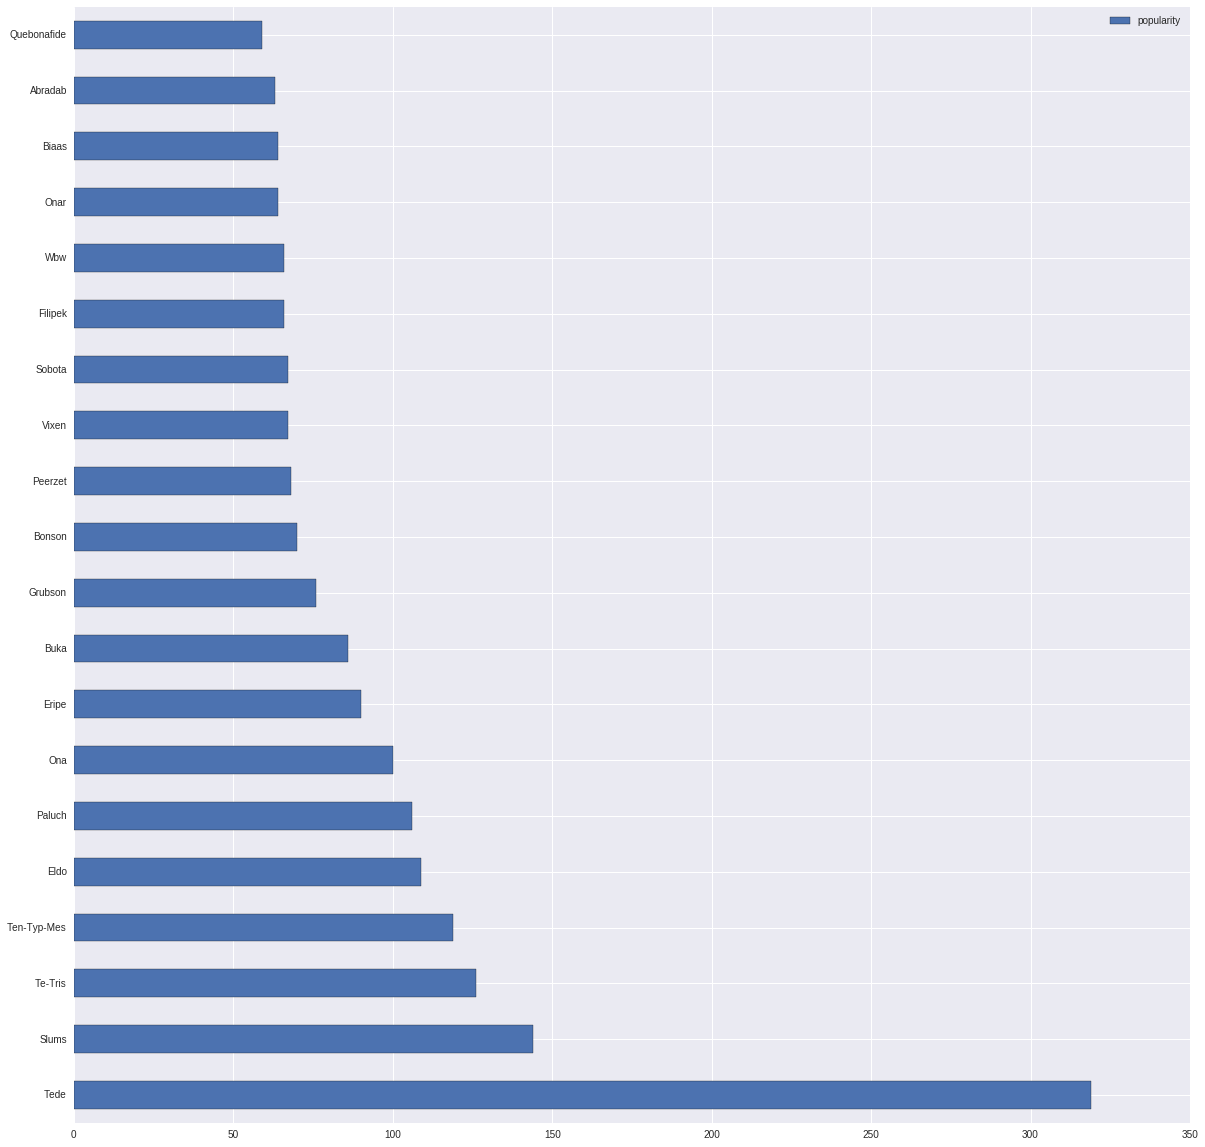

In [54]:
popularity_df = pd.DataFrame.from_dict(popularity, "index")
popularity_df.columns = ["popularity"]
popularity_df.sort_values(by="popularity", inplace=True, ascending=False)
# print(popularity_df)
popularity_df[:20].plot(kind="barh", figsize=(20,20))